# ResNet MNIST Classification
* Author: Ziad Tamim
* Description: Training ResNet with MNIST Dataset. Loading data, building the Lenet achetiture using tensorflow, training the model, and evaluating its performance.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2024-04-30 10:23:09.568916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 10:23:09.569028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 10:23:09.666025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading Training and testing data (MNIST)
* Loading the data using pandas read_csv function
* Normalising pixle values
* Adding a channle
* Resizing images [32 x 32]

In [2]:
# Load the training and test data from CSV files
train_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_df = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_test.csv')

# Assuming the first column is 'label' and the rest are pixel values
y_train = train_df['label'].values
x_train = train_df.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1) / 255.0  # Normalize pixel values

# For the test set, if it includes labels
y_test = test_df['label'].values
x_test = test_df.drop(['label'], axis=1).values.reshape(-1, 28, 28, 1) / 255.0  # Normalize pixel values


In [3]:
# Convert to 3 channels by repeating the grayscale data across three channels
x_train = np.repeat(x_train, 3, axis=3)
x_test = np.repeat(x_test, 3, axis=3)

# Optionally resize images to 32x32 for this example (you could use 224x224 for full ResNet compatibility)
x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])


In [11]:
def resnet_block(input, filters, kernel_size=3, stride=1):
    x = Conv2D(filters, kernel_size, strides=stride, padding="same")(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)

    if stride != 1 or input.shape[-1] != filters:
        input = Conv2D(filters, 1, strides=stride)(input)

    x = Add()([x, input])
    x = ReLU()(x)
    return x

def build_resnet():
    inputs = Input(shape=(32, 32, 3))
    x = Conv2D(32, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=2)(x)
    
    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 128, stride=2)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the ResNet model
model = build_resnet()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 64)  │      2,112 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 8, 8, 64)  │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 4, 128) │    147,584 │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 128) │      8,320 │ re_lu_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 4, 4, 128) │          0 │ batch_normalizat

 Total params: 325,450 (1.24 MB)

 Trainable params: 324,618 (1.24 MB)

 Non-trainable params: 832 (3.25 KB)

# Training the model
* 15 epochs
* 64 batch size

In [12]:
history = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(x_test, y_test))


Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9131 - loss: 0.2999 - val_accuracy: 0.9627 - val_loss: 0.1252
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9860 - loss: 0.0445 - val_accuracy: 0.9825 - val_loss: 0.0601
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9900 - loss: 0.0311 - val_accuracy: 0.9888 - val_loss: 0.0374
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9928 - loss: 0.0233 - val_accuracy: 0.9808 - val_loss: 0.0619
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9941 - loss: 0.0210 - val_accuracy: 0.9892 - val_loss: 0.0364
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9947 - loss: 0.0155 - val_accuracy: 0.9741 - val_loss: 0.0933
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.9836 - val_loss: 0.0579
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9949 - loss: 0.0143 - val_accuracy: 0

In [6]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9870 - loss: 0.0529
Test accuracy: 0.9894000291824341


## visualising Training Accuracy and Loss

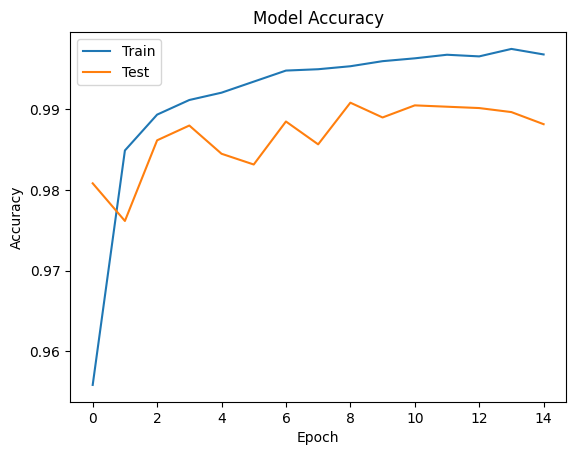

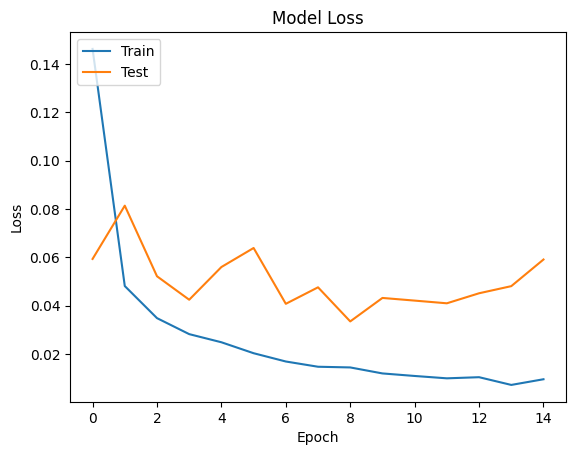

In [7]:
# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Evaluaing the model using confusion matrix and classification report

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


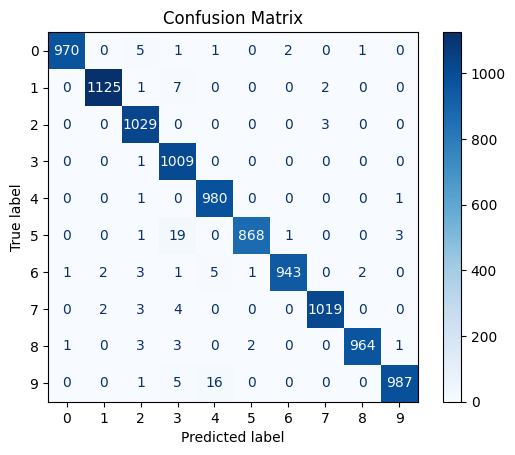

Classification Report:
               precision    recall  f1-score   support

           0     0.9979    0.9898    0.9939       980
           1     0.9965    0.9912    0.9938      1135
           2     0.9819    0.9971    0.9894      1032
           3     0.9619    0.9990    0.9801      1010
           4     0.9780    0.9980    0.9879       982
           5     0.9966    0.9731    0.9847       892
           6     0.9968    0.9843    0.9905       958
           7     0.9951    0.9912    0.9932      1028
           8     0.9969    0.9897    0.9933       974
           9     0.9950    0.9782    0.9865      1009

    accuracy                         0.9894     10000
   macro avg     0.9897    0.9892    0.9893     10000
weighted avg     0.9896    0.9894    0.9894     10000



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Predictions for the test set
prediction_scores = model.predict(x_test)
predicted_labels = np.argmax(prediction_scores, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_test, predicted_labels, digits=4)
print('Classification Report:\n', report)


## Predicting an image lable from the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


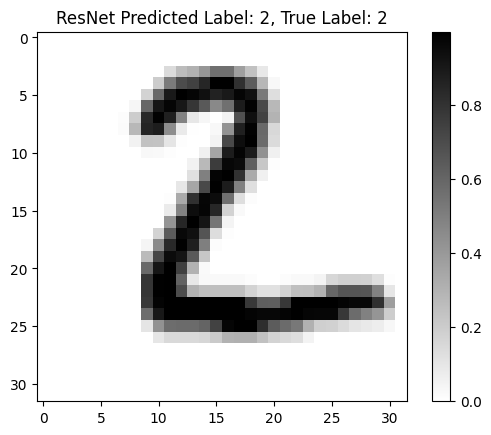

In [9]:
# Inference on a single image
img_index = 1
selected_image = x_test[img_index]
selected_label = y_test[img_index]
image_for_inference = np.expand_dims(selected_image, 0)
predictions = model.predict(image_for_inference)
predicted_label = np.argmax(predictions)

# Display the image
plt.figure()
plt.imshow(selected_image[:, :, 0], cmap=plt.cm.binary)
plt.title(f'ResNet Predicted Label: {predicted_label}, True Label: {selected_label}')
plt.colorbar()
plt.grid(False)
plt.show()